## **Using Leap Labs for Interpetability**

Let's take a pre-trained model: in this case a model trained to classify whether an image has a tank or not. So a tank classifier. Let's say that the reported accuracy of the model is approximately 90%. Before we could deploy this let's run it and test it on an image first. 

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import shutil
import requests
import random
import numpy as np
import matplotlib.pyplot as plt
import copy
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torchvision import transforms, datasets, models
from sklearn.model_selection import train_test_split
from io import BytesIO
from zipfile import ZipFile
from dotenv import load_dotenv


#For reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

# Load environment variables
load_dotenv()
#LEAP_API_KEY = os.getenv("LEAP_API_KEY")

LEAP_API_KEY = "LEAPI55301032B70D4F133B6FFA9ABAB71712"

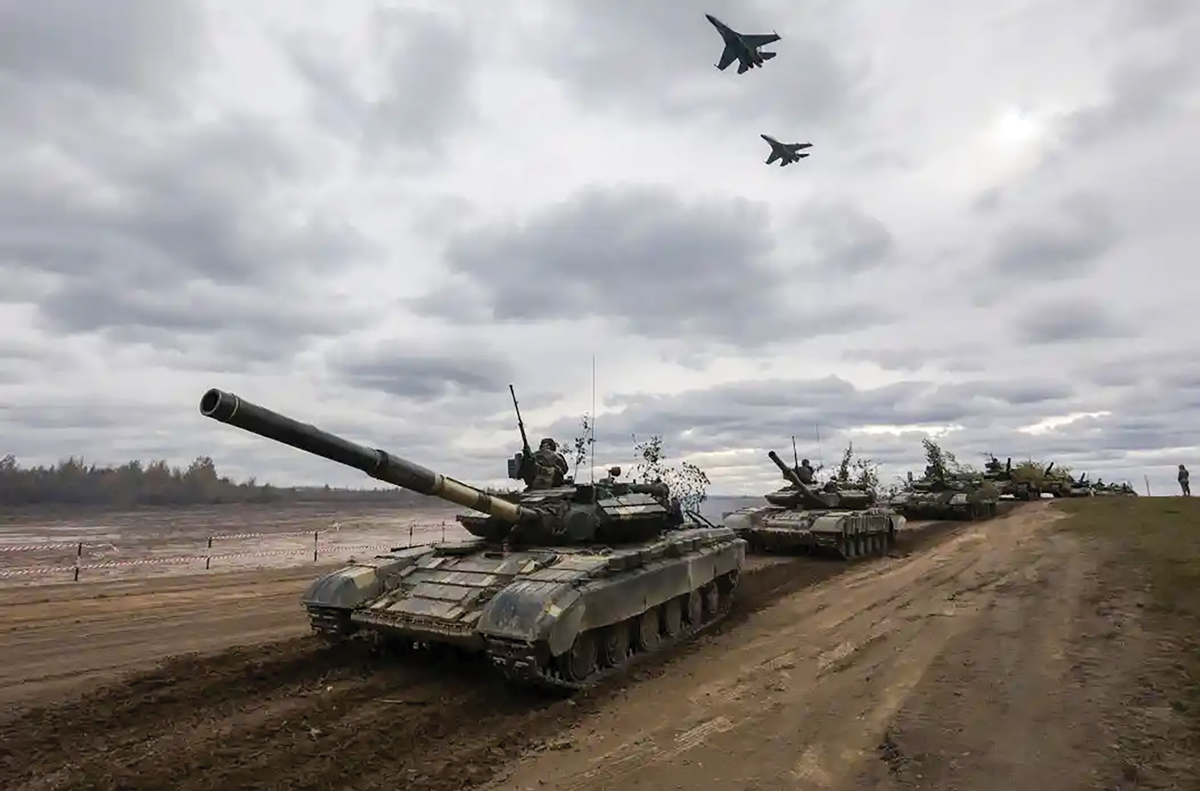

Tank Probability: 0.9889603853225708%



In [7]:
# testing the model on a tank classifier

device = "cuda" if torch.cuda.is_available() else "cpu"

def download_file(url, save_path='', return_image = False):
    r = requests.get(url)
    if return_image:
        return Image.open(BytesIO(r.content)).convert('RGB')
    if save_path != '':
        with open(save_path, 'wb') as f:
            f.write(r.content)

download_file('https://huggingface.co/J-RUM/tanks/resolve/main/tank_classifier.pth', 'tank_classifier.pth')
model = torch.load('tank_classifier.pth', weights_only=False)
model.eval()

to_tensor = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
    ])


prep = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

tank_img = download_file("https://huggingface.co/J-RUM/tanks/resolve/main/tank0.jpg", return_image=True)
display(tank_img)
tank_tensor = to_tensor(tank_img).unsqueeze(0).to(device)
print('Tank Probability: {}%\n'.format(torch.softmax(model(prep(tank_tensor)), dim=-1)[0][0].item()))

Before generating the propotypes for the model to investigate the interpretability of the model it is important to study what to *expect* from the model prototypes. That comes from the design of the model: what does it expect to classify? Is it Binary classification? Is it multi-class classification? What are the class labels? <br>

Here in this example the two classes are: `tank` and `no_tank`.  <br>

Judging by the accuracy we expect the tank classes to contain tank-like features while no_tank classes having features that are not commonly found on tank images.

100%|██████████| 1000/1000 [00:37<00:00, 26.54it/s]


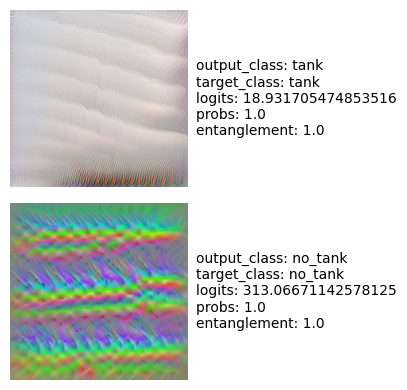

In [10]:
from leap_ie.vision import engine

leap_config = {"leap_api_key": LEAP_API_KEY}
class_list = ['tank', 'no_tank']

target_classes = [0, 1] # Assuming 'tank' is class 0 and 'no_tank' is class 1

results_df, results_dict = engine.generate(project_name="tanks", model=model, class_list=class_list, config = leap_config,
                                           target_classes = target_classes, preprocessing=prep)

engine.display_df(results_df)

Now we have the output for both the classes. But this is weird. We would expect to see some tank-like features for the tank's output but there is no such feature. So is our model looking at correct features? <br>

No_tank features also has no such clear features. It has green shade which could probably mean the model is looking at a grass and knows its not a tank but why isnt the model looking at the tank to predict tank. <br>

There is a possibility of models using "shortcuts" to learn the correct class. There is a chance the images used to train the model had a lot of cloud, or roads or any gray background such that `cloud in any image = tank` is what the model has learned. Let's validate it now.

We could look into feature isolation here. Feature Isolation helps us to provide an example image and see which pats of the image contribute towards classification. 

100%|██████████| 1000/1000 [00:19<00:00, 51.51it/s]


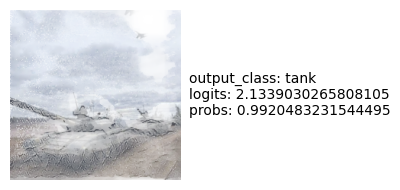

In [13]:
results_df, results_dict = engine.generate(project_name="tanks", model=model, class_list=class_list, config=leap_config,
                                          target_classes=[0], preprocessing=prep, samples=tank_tensor)
engine.display_df(results_df)

Almost the entire image is being used. The white spaces indicate portions of the images not being used to detect tank but we can also see that most of the parts of the tanks are shaded white. So the model is not taking tank itself into the account. Maybe its using the saturation or the background of the image.

To fix this spurious correlation between tanks and cloudy skies, we need to train the model further with images of tanks in all kinds of weather.

In [15]:
download_file('https://huggingface.co/J-RUM/tanks/resolve/main/train.zip?download=true', 'train.zip')
with ZipFile('train.zip', 'r') as zip_ref:
    zip_ref.extractall('train')
download_file('https://huggingface.co/J-RUM/tanks/resolve/main/val.zip?download=true', 'val.zip')
with ZipFile('val.zip', 'r') as zip_ref:
    zip_ref.extractall('val')

print(len([name for name in os.listdir('train/train/landscapes')]))
print(len([name for name in os.listdir('train/train/tanks')]))

863
863


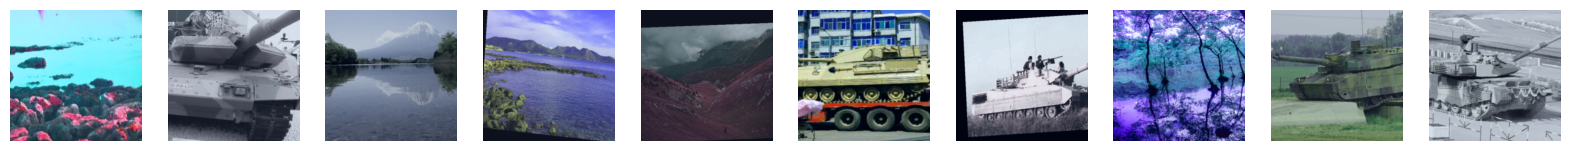

In [16]:
#lots of random transformations to avoid overfit, since our training data is small.

data_transforms = {
    'train': transforms.Compose([
    transforms.Resize(512),
    transforms.RandomAffine(degrees=5, scale=[0.7,1.3]),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=1, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


def show_images(images):
    images = (images - images.min()) / (images.max() - images.min())
    fig, axes = plt.subplots(1, len(images), figsize=(20, 10))

    if len(images) == 1:
        axes = [axes]

    for i, image in enumerate(images):
        axes[i].imshow(np.transpose(image, (1, 2, 0)))
        axes[i].axis('off')
    plt.show()

train_dataset = datasets.ImageFolder(root='train/train', transform=data_transforms['train'], target_transform=lambda x: 0 if x == 1 else 1)
val_dataset = datasets.ImageFolder(root='val/val', transform=data_transforms['val'], target_transform=lambda x: 0 if x == 1 else 1)

random_indices = random.sample(range(len(train_dataset)), 10)
show_images(torch.stack([train_dataset[i][0] for i in random_indices]))

In [17]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=1, leap_frequency=2):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        print('\nEpoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                #show_images(inputs[:10])

                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        if leap_frequency > 0 and epoch%leap_frequency == 0:
            model.eval()
            results_df, results_dict = engine.generate(project_name="tanks", model=model, class_list=class_list, config=leap_config,
                    target_classes=[0], preprocessing=prep)
            engine.display_df(results_df)

    return model


Epoch 1/5
----------
train Loss: 0.7135 Acc: 0.7294
val Loss: 0.2034 Acc: 0.9352


100%|██████████| 1000/1000 [00:18<00:00, 52.67it/s]


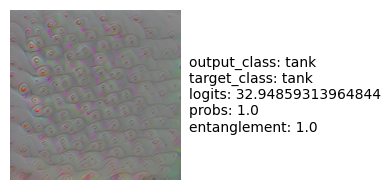


Epoch 2/5
----------
train Loss: 0.2933 Acc: 0.8720
val Loss: 0.1261 Acc: 0.9491


100%|██████████| 1000/1000 [00:18<00:00, 52.64it/s]


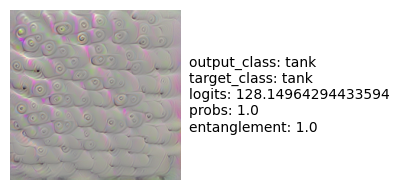


Epoch 3/5
----------
train Loss: 0.1471 Acc: 0.9490
val Loss: 0.1153 Acc: 0.9560


100%|██████████| 1000/1000 [00:18<00:00, 52.84it/s]


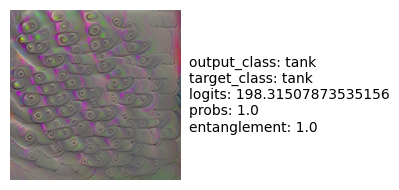


Epoch 4/5
----------
train Loss: 0.0624 Acc: 0.9844
val Loss: 0.1410 Acc: 0.9514


100%|██████████| 1000/1000 [00:18<00:00, 52.73it/s]


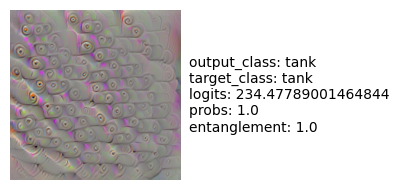


Epoch 5/5
----------
train Loss: 0.0422 Acc: 0.9832
val Loss: 0.1511 Acc: 0.9468


100%|██████████| 1000/1000 [00:18<00:00, 52.89it/s]


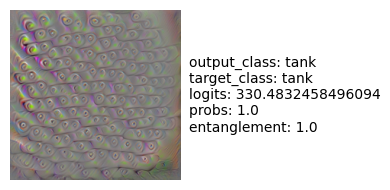

In [18]:
better_model = copy.deepcopy(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(better_model.parameters(), lr=0.0001)
num_epochs = 5
batch_size = 12

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
}

better_model = train_model(better_model, dataloaders, criterion, optimizer, num_epochs, leap_frequency=1)

torch.save(better_model, 'better_tank_classifier.pth')

Now we generate prototypes again!

100%|██████████| 1000/1000 [00:37<00:00, 26.44it/s]


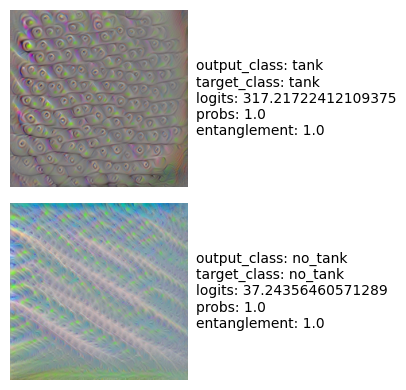

In [19]:
results_df, results_dict = engine.generate(project_name="tanks", model=better_model, class_list=class_list, config=leap_config,
                 target_classes=target_classes, preprocessing=prep)

engine.display_df(results_df)

100%|██████████| 1000/1000 [00:19<00:00, 52.07it/s]


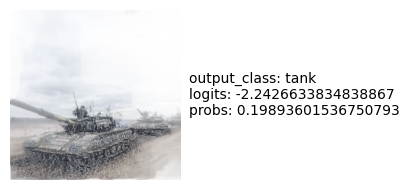

In [20]:
results_df, results_dict = engine.generate(project_name="tanks", model=better_model, class_list=class_list, config=leap_config,
                target_classes=[0], preprocessing=prep, samples=tank_tensor)

engine.display_df(results_df)